In [1]:
import os
import os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm import tqdm
from einops import rearrange, reduce, asnumpy, repeat
from collections import defaultdict
import re
import itertools
import importlib

from vgiwae.utils.stats import load_stats
from vgiwae.utils.plotting import plot_custom_stripplot, plot_cust_boxplot
from vgiwae.data.missing_data_module import MissingDataModule, DATASET, MISSINGNESS, PRE_IMPUTATION
from vgiwae.shared.vae_enums import DISTRIBUTION
from vgiwae.models.iwae import compute_smis_log_unnormalised_importance_weights

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

In [3]:
def load_vae_model(model_class, model_path, load_best_model=False):
    # Load the pre-trained model
    module = importlib.import_module('vgiwae.models')
    my_class = getattr(module, model_class)

    # Gather latest stats
    versions = os.listdir(model_path.split('version_')[0])
    versions = sorted([int(v.split('version_')[1]) for v in versions], reverse=True)
    if len(versions) > 1:
        print(f'Multiple versions in {model_path}')
    version = versions[0]
    model_path = model_path.format(version)
    if load_best_model:
        print('Finding best model.')
        model_path = model_path.split('last.ckpt')[0]
        models = os.listdir(model_path)
        models = [m for m in models if not m.startswith('last.ckpt')]
        assert len(models) == 1, f'Found multiple models in {model_path}'
        model_path = os.path.join(model_path, models[0])
    print('Using pre-trained model from:', model_path)

    # Load the model
    model = my_class.load_from_checkpoint(model_path)
    
    return model

def produce_imputations_using_importance_resampling(model, X, M, num_importance_samples, num_imputations):
    B = X.shape[0]
    with torch.inference_mode():
        var_params = model.predict_var_latent_params(X*M, M)
        var_latent_distr = model.create_distribution(var_params, model.hparams.var_latent_distribution)
        if (model.hparams.var_latent_distribution in (DISTRIBUTION.stratified_mixture5_normal_with_eps,
                                                       DISTRIBUTION.stratified_mixture15_normal_with_eps,
                                                       DISTRIBUTION.stratified_mixture25_normal_with_eps,
                                                       DISTRIBUTION.stratified_mixture1_normal_with_eps,
                                                       DISTRIBUTION.stratified_mixture1_normal,
                                                       DISTRIBUTION.stratified_mixture5_normal,
                                                       DISTRIBUTION.stratified_mixture15_normal,
                                                       DISTRIBUTION.stratified_mixture25_normal)):
            var_latent_distr.set_sample_not_stratified()
        Z = var_latent_distr.sample(sample_shape=(num_imputations, num_importance_samples))
        
        # Create prior distribution
        prior_distr = model.get_prior()

        # Create generator distribution
        generator_params = model.generator_network(Z)
        generator_distr = model.create_distribution(generator_params, model.hparams.generator_distribution)

        # Compute importance weights
        log_weights = compute_smis_log_unnormalised_importance_weights(X, M, Z,
                                                                       var_latent_distr,
                                                                       prior_distr,
                                                                       generator_distr)
        
        log_weights = rearrange(log_weights, 'z i b -> z b i')
        imp_distr = torch.distributions.Categorical(logits=log_weights)
        
        idx = imp_distr.sample()
        generator_params = rearrange(generator_params, 'z i b ... -> z b i ...')
        generator_params = generator_params[torch.arange(num_imputations)[:, None], torch.arange(B)[None, :], idx]
        
        # Sample imps
        generator_params = rearrange(generator_params, 'z b ... -> b z ...')
        generator_distr = model.create_distribution(generator_params, model.hparams.generator_distribution)
        X_imps = generator_distr.sample()

        X_imps = (X*M)[:, None, :] + X_imps*(~M)[:, None, :]
        return X_imps

## FID 

In [125]:
seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'mnist_bin', 
    'omniglot_28x28_bin', 
]

models_by_dataset = {}
models_by_dataset['mnist_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_dr03_z5_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_dr03_i5_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

models_by_dataset['omniglot_28x28_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
    # MultipleVAE2
    {
        'name': 'multiple2_vae_dr03_z5_stl',
        'label_name': 'Miss(S)VAE'
    },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
    # MultipleIWAE2
    {
        'name': 'multiple2_iwae_dr03_i5_stl',
        'label_name': 'Miss(S)IWAE'
    },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

missingness = ['q50']

log_dir_template = '../logs/{}/compare/{}/{}/{}/lightning_logs/'

metrics = [
    'fid_score/train',
    'fid_score/val',
    'fid_score/test',
]


model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for seed in seeds:
                log_dir = log_dir_template.format(dataset, miss, model['name'], seed)
                
                try:
                    stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                    for m in metrics:
                        model_stats[dataset][miss][model['label_name']][m].append(stats[m])
                except e:
                    print(f'Error for {log_dir=}:', e)
                    continue

100%|███████████████████████████████████████████████████████████| 2/2 [07:45<00:00, 232.72s/it]


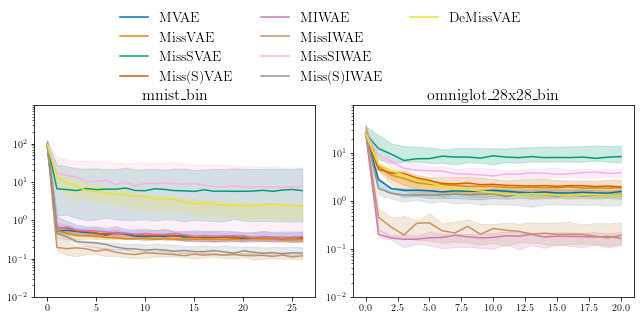

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(9,4.5), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['mnist_bin']))
colors += ['r', 'g', 'b', 'c', 'm']

missingness = 'q50'
metric = 'fid_score/test'
use_log_scale = True


for i, dataset in enumerate(datasets):
    for m, model in enumerate(models_by_dataset[dataset]):
        stat = model_stats[dataset][miss][model['label_name']][metric]
        stat = np.column_stack(list(itertools.zip_longest(*stat, fillvalue=float('nan'))))
        stat = np.array(stat)

        # Plot in log-domain
        if use_log_scale:
            stat = np.log(stat)

        median = np.nanmedian(stat, axis=0)
        low_ci = np.nanquantile(stat, 0.05, axis=0)
        high_ci = np.nanquantile(stat, 0.95, axis=0)
        axes[i].plot(np.arange(len(median)), median, color=colors[m], label=model['label_name'])
        axes[i].fill_between(np.arange(len(median)), low_ci, high_ci, color=colors[m], alpha=.2)

    if use_log_scale:
        axes[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[i].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[i].yaxis.set_ticks(tick_range)
        axes[i].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)

    axes[i].set_title(dataset, fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout(rect=(0, 0, 1, 0.76))

## Log-likelihood estimate (IWAE bound)

In [62]:
seeds = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'mnist_bin', 
    'omniglot_28x28_bin', 
]

models_by_dataset = {}
models_by_dataset['mnist_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_dr03_z5_stl',
#         'label_name': 'Miss(S)VAE'
#     },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_dr03_i5_stl',
#         'label_name': 'Miss(S)IWAE'
#     },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

models_by_dataset['omniglot_28x28_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_dr03_z5_stl',
#         'label_name': 'Miss(S)VAE'
#     },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_dr03_i5_stl',
#         'label_name': 'Miss(S)IWAE'
#     },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

missingness = ['q50']

log_dir_template = '../logs/{}/compare/refit_encoder_testcomp/{}/{}/{}/lightning_logs/'

metrics = [
    'est_loglik/test_epoch',
]


loglik_model_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for seed in seeds:
                log_dir = log_dir_template.format(dataset, miss, model['name'], seed)
                
                try:
                    stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                    for m in metrics:
                        loglik_model_stats[dataset][miss][model['label_name']][m].append(stats[m])
                except Exception as e:
                    print(f'Error for {log_dir=}:', e)
                    continue

100%|████████████████████████████████████████████████████████████| 2/2 [00:33<00:00, 16.87s/it]


In [63]:
dataset_label_map = {
    'mnist_bin': 'MNIST',
    'omniglot_28x28_bin': 'Omniglot',
}

/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.stripplot(
/home/vaidas/Projects/vgiwae/vgiwae/utils/plotting.py:65: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.stripplot(


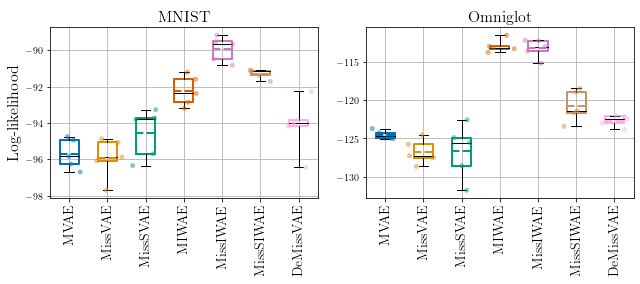

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), sharex=False, sharey=False)

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['mnist_bin']))
colors += ['r', 'g', 'b', 'c', 'm']

metric0 = 'est_loglik/test_epoch'
missingness = 'q50'

for d, (dataset, data_stats) in enumerate(loglik_model_stats.items()):
    model_label_names = [v['label_name'] for v in models_by_dataset[dataset]]
    
#     metric_box_data = defaultdict(list)
#     missingness_labels = list(data_stats.keys())
#     stats = defaultdict(list)
#     for i, model in enumerate(model_label_names):
#         stats_model = []
#         for m in missingness_labels:
#             stats_model.append(np.array(data_stats[m][model][metric0]).flatten())
#         stats_model = np.array(stats_model)
        
#         median = np.nanmean(stats_model, axis=-1)
#         low_ci = np.nanquantile(stats_model, 0.05, axis=-1)
#         high_ci = np.nanquantile(stats_model, 0.95, axis=-1)
#         axes[d].plot(missingness_labels, median, color=colors[i], label=model)
#         axes[d].fill_between(missingness_labels, low_ci, high_ci, color=colors[i], alpha=.2)
        
#         axes[d].set_title(dataset, fontsize=16)

    metric_box_data = defaultdict(list)
    model_labels = []
    for i, (model, stats) in enumerate(loglik_model_stats[dataset][missingness].items()):
        model_labels.append(model)
        st = np.array(stats[metric0])[..., -1]
        metric_box_data[metric0].append(st)

    plot_cust_boxplot(axes[d], metric_box_data[metric0], model_labels,
                  colors=colors,
                  meanline=True, showmeans=True,
                  showfliers=False,)
    plot_custom_stripplot(axes[d], metric_box_data[metric0], model_labels, 
                          colors=colors,
                          no_trim=True, only_trim_up=False, 
                          showmedians=False, 
                          use_log_scale=False,
                          stripplot_kw={'alpha': 0.5})
        
    axes[d].grid()
    axes[d].set_title(dataset_label_map[dataset], fontsize=16)

axes[0].set_ylabel('Log-likelihood', fontsize=16)

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=14, ha='center')

handles, labels = axes[0].get_legend_handles_labels()
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout()

# fig.savefig('figures/mnist_omniglot-complete-test-loglikelihood.pdf', bbox_inches='tight')

## Components weights analysis

### MNIST 

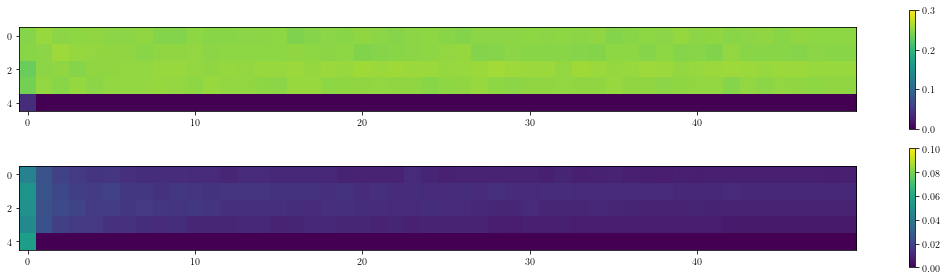

In [124]:
mnist_weights = np.load('../logs/mnist_bin/compare/q50/multiple_iwae_dr03_i5_stl_log_var_mixture_weights/seed_m20220118_d20220118/lightning_logs/version_1771081/mixture_var_weight_logits.npz')
mnist_weights = mnist_weights['mixture_weight_logits']

fig, ax = plt.subplots(2,1, figsize=(15,4))
im = ax[0].imshow(np.exp(mnist_weights).mean(axis=1).T, vmin=0, vmax=0.3)
fig.colorbar(im, ax=ax[0], location='right', anchor=(0, 0.0), shrink=1)

im = ax[1].imshow(np.exp(mnist_weights).std(axis=1).T, vmin=0, vmax=0.1)
fig.colorbar(im, ax=ax[1], location='right', anchor=(0, 0.0), shrink=1)

fig.tight_layout()

Text(0.5, 0, 'iteration')

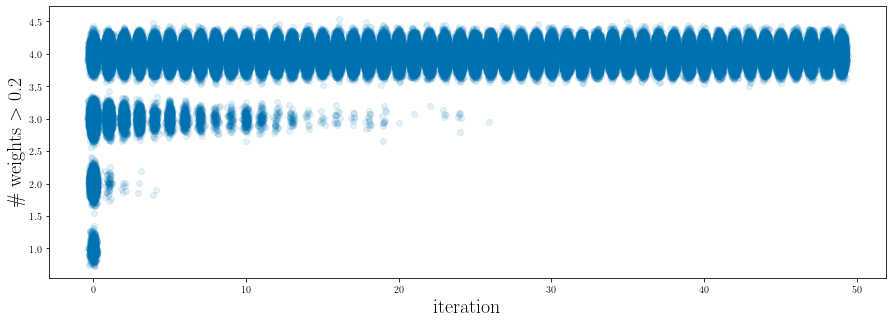

In [116]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

eps = 0.2
data = (np.exp(mnist_weights) > eps).sum(-1)
it = repeat(np.arange(data.shape[0]), 'd -> d k', k=data.shape[-1])
ax.scatter(it.flatten()+ 0.1*np.random.randn(it.flatten().shape[0]), data.flatten() + 0.1*np.random.randn(data.flatten().shape[0]),
          alpha=0.1)

ax.set_ylabel(f'\# weights $>$ {eps}', fontsize=20)
ax.set_xlabel('iteration', fontsize=20)

### Omniglot

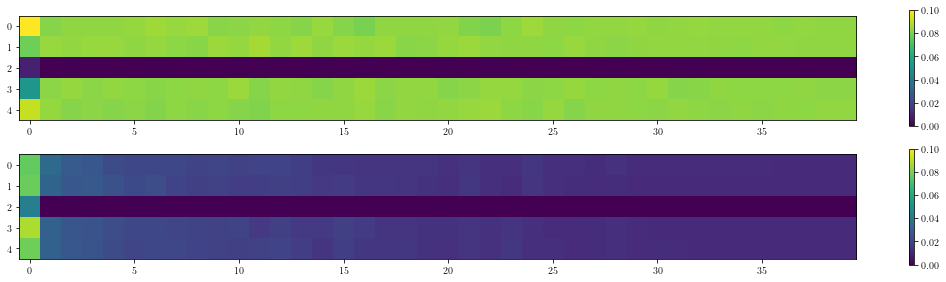

In [122]:
omni_weights = np.load('../logs/omniglot_28x28_bin/compare/q50/multiple_iwae_dr03_i5_stl_log_var_mixture_weights/seed_m20220118_d20220118/lightning_logs/version_1771080/mixture_var_weight_logits.npz')
omni_weights = omni_weights['mixture_weight_logits']


fig, ax = plt.subplots(2,1, figsize=(15,4))
ax[0].imshow(np.exp(omni_weights).mean(axis=1).T, vmin=0, vmax=0.3)
fig.colorbar(im, ax=ax[0], location='right', anchor=(0, 0.0), shrink=1)

im = ax[1].imshow(np.exp(omni_weights).std(axis=1).T, vmin=0, vmax=0.1)
fig.colorbar(im, ax=ax[1], location='right', anchor=(0, 0.0), shrink=1)

fig.tight_layout()

Text(0.5, 0, 'iteration')

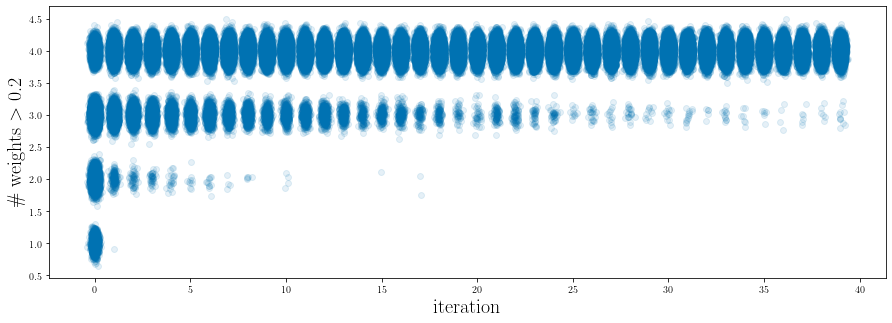

In [123]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

eps = 0.2
data = (np.exp(omni_weights) > eps).sum(-1)
it = repeat(np.arange(data.shape[0]), 'd -> d k', k=data.shape[-1])
ax.scatter(it.flatten()+ 0.1*np.random.randn(it.flatten().shape[0]), data.flatten() + 0.1*np.random.randn(data.flatten().shape[0]),
          alpha=0.1)

ax.set_ylabel(f'\# weights $>$ {eps}', fontsize=20)
ax.set_xlabel('iteration', fontsize=20)

## Model size comparison (MNIST)

In [44]:
seeds_model_size = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'mnist_bin', 
#     'omniglot_28x28_bin', 
]

models_by_dataset = {}
models_by_dataset['mnist_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_dr03_z5_stl',
#         'label_name': 'Miss(S)VAE'
#     },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_dr03_i5_stl',
#         'label_name': 'Miss(S)IWAE'
#     },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

missingness = ['q50']

model_size = ['x025', 'x05', 'x1', 'x2']

log_dir_template = '../logs/{}/compare/model_size/refit_encoder_testcomp/{}/{}/{}/{}/lightning_logs/'
log_dir_template_x1 = '../logs/{}/compare/refit_encoder_testcomp/{}/{}/{}/lightning_logs/'

metrics = [
    'est_loglik/test_epoch',
]


model_size_stats = defaultdict(lambda: defaultdict
                                 (lambda: defaultdict
                                  (lambda: defaultdict
                                   (lambda: defaultdict(list)))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for size in model_size:
                for seed in seeds_model_size:
                    if size == 'x1':
                        # Load the standard model
                        log_dir = log_dir_template_x1.format(dataset, miss, model['name'], seed)
                    else:
                        # Load the over/under-sized model
                        log_dir = log_dir_template.format(dataset, size, miss, model['name'], seed)

                    try:
                        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                        for m in metrics:
                            model_size_stats[dataset][miss][model['label_name']][m][size].append(stats[m])
                    except Exception as e:
                        print(f'Error for {log_dir=}:', e)
                    continue

100%|███████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.52s/it]


In [18]:
dataset_label_map = {
    'mnist_bin': 'MNIST',
    'omniglot_28x28_bin': 'Omniglot',
}

NameError: name 'model_size_stats' is not defined

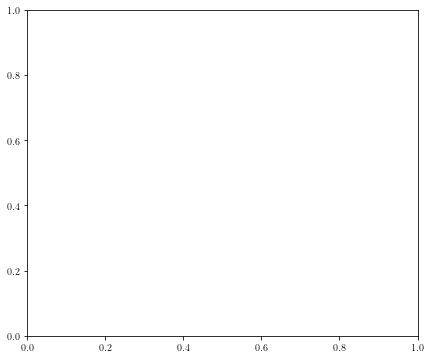

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7,6), sharex=False, sharey=False)
axes = np.array([[axes]])

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['mnist_bin']))
colors += ['r', 'g', 'b', 'c', 'm']

metric = metrics[0]
use_log_scale = False

model_params = [1.275, 2.3, 4.7, 9.4]

for i, dataset in enumerate(datasets):
    for j, miss in enumerate(missingness):
        for m, model in enumerate(models_by_dataset[dataset]):
            stat = model_size_stats[dataset][miss][model['label_name']][metric]
            stat = {k: np.array(v) for k,v in stat.items()}
            stat = np.hstack([v for k, v in stat.items()])
            
            # Plot in log-domain
            if use_log_scale:
                stat = np.log(stat)
            
            median = np.nanmedian(stat, axis=0)
            low_ci = np.nanquantile(stat, 0.05, axis=0)
            high_ci = np.nanquantile(stat, 0.95, axis=0)
            axes[i][j].plot(model_params, 
                            median, color=colors[m], label=model['label_name'])
            axes[i][j].fill_between(model_params
                                    , low_ci, high_ci, color=colors[m], alpha=.2)
        
        if use_log_scale:
            axes[i,j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
            ymin, ymax = axes[i,j].get_ylim()
            tick_range = np.arange(np.floor(ymin), ymax)
            axes[i,j].yaxis.set_ticks(tick_range)
            axes[i,j].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        
        axes[i,j].set_title(dataset_label_map[dataset], fontsize=16)

axes[0,0].set_ylabel('Log-likelihood', fontsize=14)
axes[0,0].set_xlabel('Model parameters (M)', fontsize=14)
axes[0,0].grid()

handles, labels = axes[0, 0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout(rect=(0, 0, 1, 0.8))

# fig.savefig('figures/mnist_model_size.pdf', bbox_inches='tight')

## Latent size comparison (MNIST)

In [5]:
seeds_model_size = ['seed_m20220118_d20220118',
         'seed_m2022011811_d2022011811',
         'seed_m2022011822_d2022011822',
         'seed_m2022011833_d2022011833',
         'seed_m2022011844_d2022011844'
        ]

datasets = [
    'mnist_bin', 
    'omniglot_28x28_bin', 
]

models_by_dataset = {}
models_by_dataset['mnist_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_dr03_z5_stl',
#         'label_name': 'Miss(S)VAE'
#     },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_dr03_i5_stl',
#         'label_name': 'Miss(S)IWAE'
#     },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

models_by_dataset['omniglot_28x28_bin'] = [
    # VAE
    {
        'name': 'vae_dr03_z5_stl',
        'label_name': 'MVAE'
    },
    # RMixVAE
    {
        'name': 'reparametrisedmixture_vae_dr03_z5_stl',
        'label_name': 'MissVAE'
    },
    # MultipleVAE
    {
        'name': 'multiple_vae_dr03_z5_stl',
        'label_name': 'MissSVAE'
    },
#     # MultipleVAE2
#     {
#         'name': 'multiple2_vae_dr03_z5_stl',
#         'label_name': 'Miss(S)VAE'
#     },
    # IWAE
    {
        'name': 'iwae_dr03_i5_stl',
        'label_name': 'MIWAE'
    },
    # RMixIWAE
    {
        'name': 'reparametrisedmixture_iwae_dr03_i5_stl',
        'label_name': 'MissIWAE'
    },
    # MultipleIWAE
    {
        'name': 'multiple_iwae_dr03_i5_stl',
        'label_name': 'MissSIWAE'
    },
#     # MultipleIWAE2
#     {
#         'name': 'multiple2_iwae_dr03_i5_stl',
#         'label_name': 'Miss(S)IWAE'
#     },
    # MVBVAE
    {
        'name': 'mvb2vae_noencm_pg_k5_stl',
        'label_name': 'DeMissVAE'
    },
]

missingness = ['q50']

model_size = ['x05', 'x1', 'x2', 'x4']

log_dir_template = '../logs/{}/compare/num_latents/refit_encoder_testcomp/{}/{}/{}/{}/lightning_logs/'
log_dir_template_x1 = '../logs/{}/compare/refit_encoder_testcomp/{}/{}/{}/lightning_logs/'

metrics = [
    'est_loglik/test_epoch',
]


num_latents_stats = defaultdict(lambda: defaultdict
                                 (lambda: defaultdict
                                  (lambda: defaultdict
                                   (lambda: defaultdict(list)))))
for dataset in tqdm(datasets):
    for miss in missingness:
        for model in models_by_dataset[dataset]:
            for size in model_size:
                for seed in seeds_model_size:
                    if size == 'x1':
                        # Load the standard model
                        log_dir = log_dir_template_x1.format(dataset, miss, model['name'], seed)
                    else:
                        # Load the over/under-sized model
                        log_dir = log_dir_template.format(dataset, size, miss, model['name'], seed)

                    try:
                        stats = load_stats(log_dir, stat_keys=['epoch', *metrics])
                        for m in metrics:
                            num_latents_stats[dataset][miss][model['label_name']][m][size].append(stats[m])
                    except Exception as e:
                        print(f'Error for {log_dir=}:', e)
                    continue

100%|████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.65s/it]


In [20]:
dataset_label_map = {
    'mnist_bin': 'MNIST',
    'omniglot_28x28_bin': 'Omniglot',
}

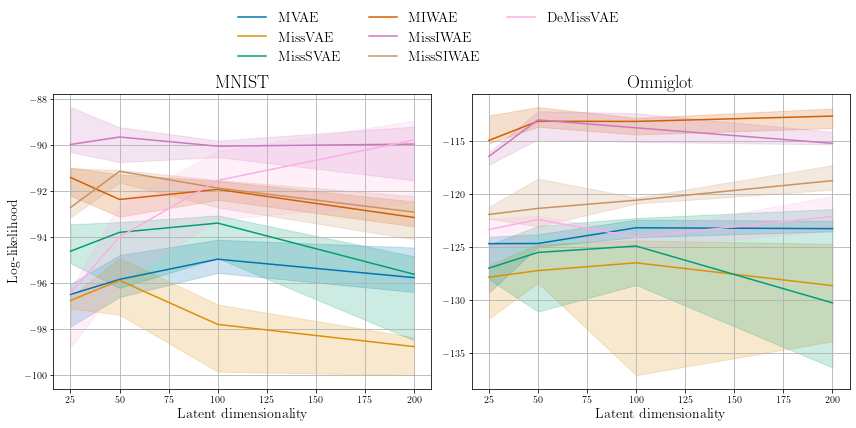

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=False, sharey=False)
# axes = np.array([[axes]])
axes = np.array([axes]).T

colors = sns.color_palette(palette='colorblind', n_colors=len(models_by_dataset['mnist_bin']))
colors += ['r', 'g', 'b', 'c', 'm']

metric = metrics[0]
use_log_scale = False

num_latents = [25, 50, 100, 200]

for i, dataset in enumerate(datasets):
    for j, miss in enumerate(missingness):
        for m, model in enumerate(models_by_dataset[dataset]):
            stat = num_latents_stats[dataset][miss][model['label_name']][metric]
            stat = {k: np.array(v) for k,v in stat.items()}
#             stat = np.hstack([v for k, v in stat.items()])
            
            stat = list(itertools.zip_longest(*[v.tolist() for k, v in stat.items()], fillvalue=[float('nan')]))
            stat = np.hstack(stat).T
            
            # Plot in log-domain
            if use_log_scale:
                stat = np.log(stat)
            
            median = np.nanmedian(stat, axis=0)
            low_ci = np.nanquantile(stat, 0.05, axis=0)
            high_ci = np.nanquantile(stat, 0.95, axis=0)
            axes[i][j].plot(num_latents, 
                            median, color=colors[m], label=model['label_name'])
            axes[i][j].fill_between(num_latents
                                    , low_ci, high_ci, color=colors[m], alpha=.2)
        
        if use_log_scale:
            axes[i,j].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
            ymin, ymax = axes[i,j].get_ylim()
            tick_range = np.arange(np.floor(ymin), ymax)
            axes[i,j].yaxis.set_ticks(tick_range)
            axes[i,j].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
        
        axes[i,j].set_title(dataset_label_map[dataset], fontsize=18)

axes[0,0].set_ylabel('Log-likelihood', fontsize=14)
axes[0,0].set_xlabel('Latent dimensionality', fontsize=14)
axes[0,0].grid()
axes[1,0].set_xlabel('Latent dimensionality', fontsize=14)
axes[1,0].grid()
            
handles, labels = axes[0, 0].get_legend_handles_labels()
handles += [mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False), 
            mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                 visible=False)
           ]
labels += ['', '']
plt.figlegend(handles, labels,
              ncol=3, loc='upper center',
              frameon=False, fontsize=14)

fig.tight_layout(rect=(0, 0, 1, 0.85))

# fig.savefig('figures/mnist_omni_num_latents.pdf', bbox_inches='tight')

## Imputation (MNIST)

In [40]:
datamodule_mnist = MissingDataModule(DATASET['mnist_bin'],
                         batch_size=200,
                         missingness=MISSINGNESS['quadrants'],
                         img_dims=[ 28, 28 ],
                         total_miss_train=0.5,
                         total_miss_val=0.5,
                         total_miss_test=0.5,
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
datamodule_mnist.setup(stage='fit')
datamodule_mnist.setup(stage='test')

Train data size: 54000
Validation data size: 6000
Test data size: 10000


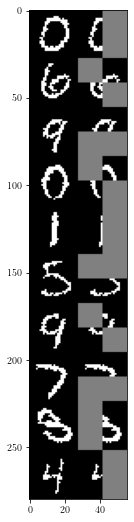

In [41]:
X, M = datamodule_mnist.test_data[10:20][:2]
X = torch.tensor(X)
M = torch.tensor(M)

X_img = rearrange(X, ('b (x y) -> b x y'), x=28)
M_img = rearrange(M, ('b (x y) -> b x y'), x=28)
img = torch.stack((X_img, X_img*M_img), dim=1)
img = rearrange(img, 'b k x y -> (b x) (k y)') 

fig, axes = plt.subplots(1, 1, figsize=(9, 9))
axes.imshow(img, vmin=-1, vmax=1, cmap='gray')

In [43]:
imp_models = {
    'VAE': {
        'model_class': 'VAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissVAE': {
        'model_class': 'VAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/reparametrisedmixture_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSVAE': {
        'model_class': 'MultipleVAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/multiple_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'IWAE': {
        'model_class': 'IWAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissIWAE': {
        'model_class': 'IWAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/reparametrisedmixture_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSIWAE': {
        'model_class': 'MultipleIWAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50/multiple_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'DeMissVAE': {
        'model_class': 'MVBVAE_FID',
        'checkpoint': '../logs/mnist_bin/compare/q50_train_enc_refit/mvb2vae_noencm_pg_k5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    }
}


num_importance_samples = 100
num_imputations = 10
mnist_model_imps = {}
for model_name, cfg in tqdm(imp_models.items()):
    model = load_vae_model(cfg['model_class'], 
                           cfg['checkpoint'],
                           load_best_model=False)
    
    X_imps = produce_imputations_using_importance_resampling(model, X, M, 
                                                num_importance_samples=num_importance_samples, 
                                                num_imputations=num_imputations)
    mnist_model_imps[model_name] = X_imps

  0%|                                                                    | 0/7 [00:00<?, ?it/s]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1766748/checkpoints/last.ckpt


 14%|████████▌                                                   | 1/7 [00:13<01:19, 13.23s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/reparametrisedmixture_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1771362/checkpoints/last.ckpt


 29%|█████████████████▏                                          | 2/7 [00:27<01:08, 13.67s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/multiple_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1766691/checkpoints/last.ckpt


 43%|█████████████████████████▋                                  | 3/7 [00:40<00:54, 13.53s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1766741/checkpoints/last.ckpt


 57%|██████████████████████████████████▎                         | 4/7 [00:54<00:40, 13.65s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/reparametrisedmixture_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1771162/checkpoints/last.ckpt


 71%|██████████████████████████████████████████▊                 | 5/7 [01:07<00:27, 13.59s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50/multiple_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1766747/checkpoints/last.ckpt


 86%|███████████████████████████████████████████████████▍        | 6/7 [01:21<00:13, 13.62s/it]

Using pre-trained model from: ../logs/mnist_bin/compare/q50_train_enc_refit/mvb2vae_noencm_pg_k5_stl/seed_m20220118_d20220118/lightning_logs/version_1777799/checkpoints/last.ckpt


100%|████████████████████████████████████████████████████████████| 7/7 [01:35<00:00, 13.59s/it]


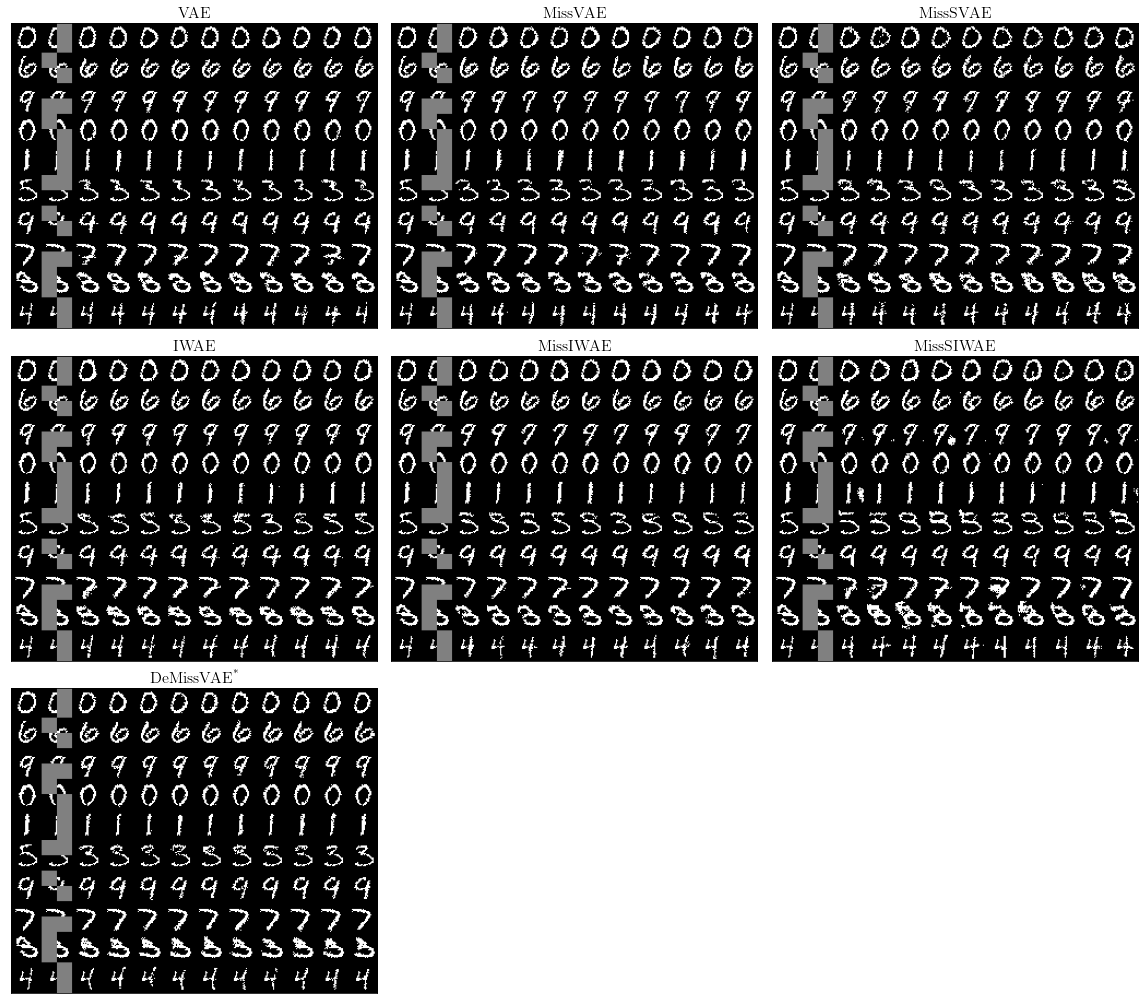

In [44]:
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, (model_name, X_imps) in enumerate(mnist_model_imps.items()):
    X_img = rearrange(X, ('b (x y) -> b x y'), x=28)
    M_img = rearrange(M, ('b (x y) -> b x y'), x=28)
    X_imps_img = rearrange(X_imps, ('b k (x y) -> b k x y'), x=28)
    img = torch.cat([torch.stack((X_img, X_img*M_img), dim=1),
                     X_imps_img], dim=1)
    img = rearrange(img, 'b k x y -> (b x) (k y)') 

    axes[i].imshow(img, vmin=-1, vmax=1, cmap='gray')
    if 'DeMissVAE' in model_name:
        model_name = model_name + '\\textsuperscript{*}'
    axes[i].set_title(model_name, fontsize=16)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
for j in range(len(axes)-len(omni_model_imps)):
    axes[-j-1].remove()

fig.tight_layout()

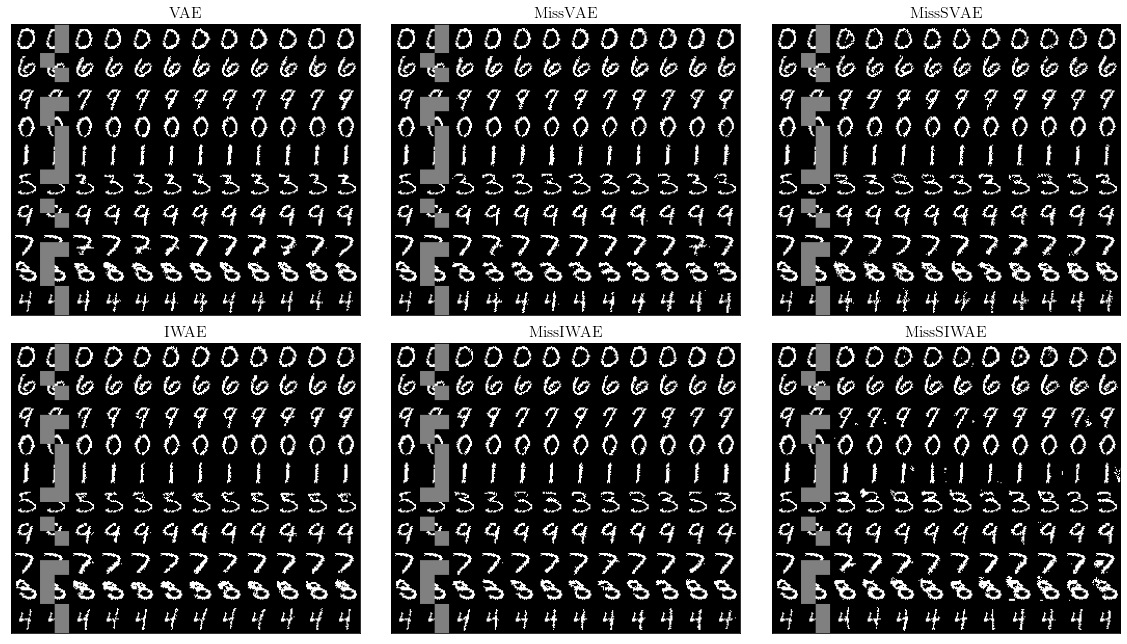

In [167]:
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, (model_name, X_imps) in enumerate(omni_model_imps.items()):
    X_img = rearrange(X, ('b (x y) -> b x y'), x=28)
    M_img = rearrange(M, ('b (x y) -> b x y'), x=28)
    X_imps_img = rearrange(X_imps, ('b k (x y) -> b k x y'), x=28)
    img = torch.cat([torch.stack((X_img, X_img*M_img), dim=1),
                     X_imps_img], dim=1)
    img = rearrange(img, 'b k x y -> (b x) (k y)')

    axes[i].imshow(img, vmin=-1, vmax=1, cmap='gray')
    axes[i].set_title(model_name, fontsize=16)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
for j in range(len(axes)-len(omni_model_imps)):
    axes[-j-1].remove()

fig.tight_layout()

## Imputation (Omniglot)

In [22]:
datamodule_omni = MissingDataModule(DATASET['omniglot_28x28_bin'],
                         batch_size=200,
                         missingness=MISSINGNESS['quadrants'],
                         img_dims=[ 28, 28 ],
                         total_miss_train=0.5,
                         total_miss_val=0.5,
                         total_miss_test=0.5,
                         pre_imputation=PRE_IMPUTATION['oracle'],
                         pre_impute_val=True,
                         filter_fully_missing_train=True,
                         filter_fully_missing_val=True,
                         data_root="../data",
                         setup_seed=20220118)
datamodule_omni.setup(stage='fit')
datamodule_omni.setup(stage='test')

Train data size: 27396
Validation data size: 194
Test data size: 4870


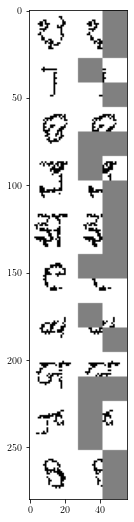

In [23]:
X, M = datamodule_omni.test_data[10:20][:2]
X = torch.tensor(X)
M = torch.tensor(M)

X_img = rearrange(X, ('b (x y) -> b x y'), x=28)
M_img = rearrange(M, ('b (x y) -> b x y'), x=28)
img = torch.stack((X_img, X_img*M_img), dim=1)
img = rearrange(img, 'b k x y -> (b x) (k y)')

fig, axes = plt.subplots(1, 1, figsize=(9, 9))
axes.imshow(img, vmin=-1, vmax=1, cmap='gray')

In [29]:
imp_models = {
    'VAE': {
        'model_class': 'VAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissVAE': {
        'model_class': 'VAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/reparametrisedmixture_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSVAE': {
        'model_class': 'MultipleVAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/multiple_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'IWAE': {
        'model_class': 'IWAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissIWAE': {
        'model_class': 'IWAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/reparametrisedmixture_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'MissSIWAE': {
        'model_class': 'MultipleIWAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50/multiple_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    },
    'DeMissVAE': {
        'model_class': 'MVBVAE_FID',
        'checkpoint': '../logs/omniglot_28x28_bin/compare/q50_train_enc_refit/mvb2vae_noencm_pg_k5_stl/seed_m20220118_d20220118/lightning_logs/version_{}/checkpoints/last.ckpt'
    }
}


num_importance_samples = 100
num_imputations = 10
omni_model_imps = {}
for model_name, cfg in tqdm(imp_models.items()):
    model = load_vae_model(cfg['model_class'], 
                           cfg['checkpoint'],
                           load_best_model=False)
    
    X_imps = produce_imputations_using_importance_resampling(model, X, M, 
                                                num_importance_samples=num_importance_samples, 
                                                num_imputations=num_imputations)
    omni_model_imps[model_name] = X_imps

  0%|                                                                    | 0/7 [00:00<?, ?it/s]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1766661/checkpoints/last.ckpt


 14%|████████▌                                                   | 1/7 [00:36<03:41, 36.87s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/reparametrisedmixture_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1771357/checkpoints/last.ckpt


 29%|█████████████████▏                                          | 2/7 [01:13<03:03, 36.72s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/multiple_vae_dr03_z5_stl/seed_m20220118_d20220118/lightning_logs/version_1766649/checkpoints/last.ckpt


 43%|█████████████████████████▋                                  | 3/7 [01:50<02:26, 36.72s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1766659/checkpoints/last.ckpt


 57%|██████████████████████████████████▎                         | 4/7 [02:26<01:50, 36.71s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/reparametrisedmixture_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1771157/checkpoints/last.ckpt


 71%|██████████████████████████████████████████▊                 | 5/7 [03:04<01:13, 36.88s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50/multiple_iwae_dr03_i5_stl/seed_m20220118_d20220118/lightning_logs/version_1766660/checkpoints/last.ckpt


 86%|███████████████████████████████████████████████████▍        | 6/7 [03:40<00:36, 36.87s/it]

Using pre-trained model from: ../logs/omniglot_28x28_bin/compare/q50_train_enc_refit/mvb2vae_noencm_pg_k5_stl/seed_m20220118_d20220118/lightning_logs/version_1777804/checkpoints/last.ckpt


100%|████████████████████████████████████████████████████████████| 7/7 [04:18<00:00, 36.87s/it]


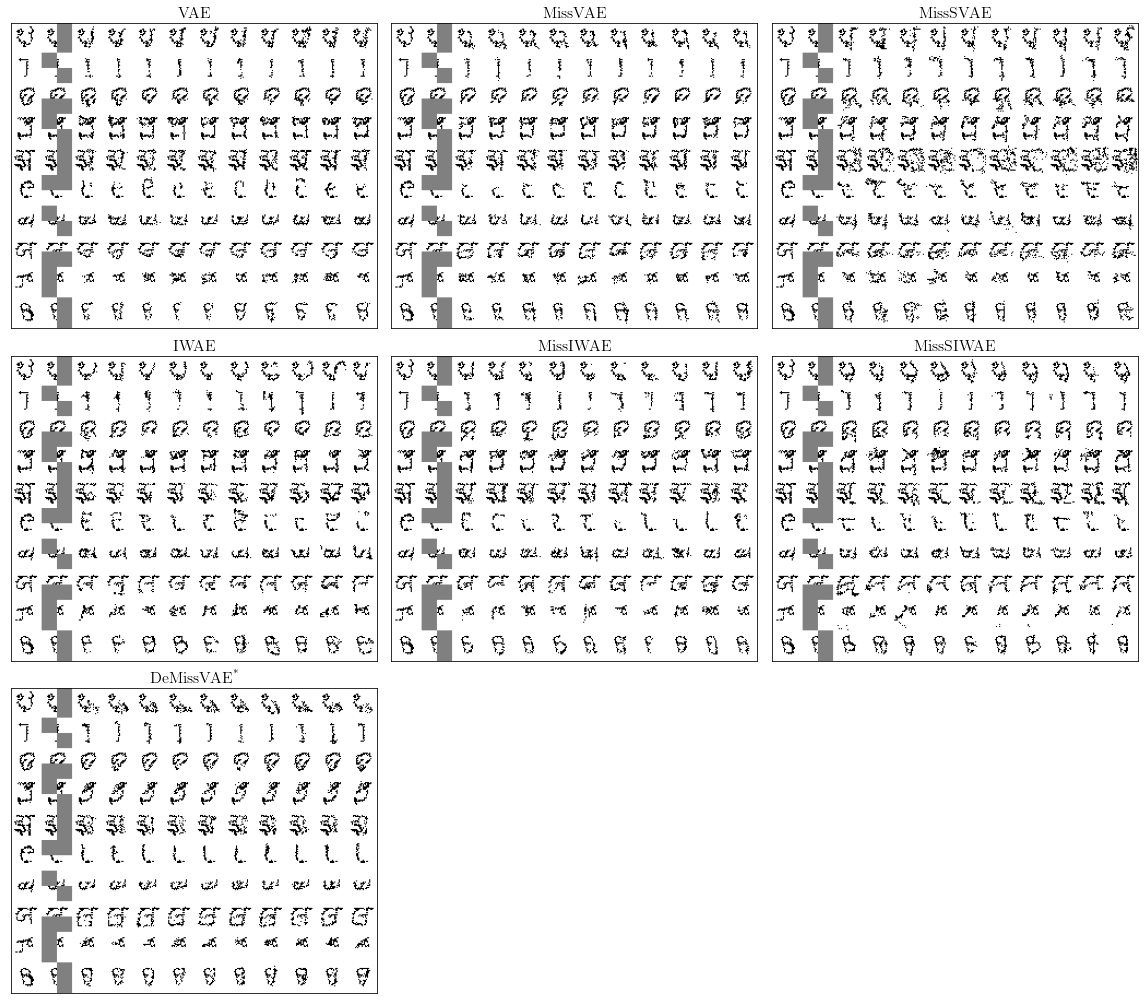

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.flatten()

for i, (model_name, X_imps) in enumerate(omni_model_imps.items()):
    X_img = rearrange(X, ('b (x y) -> b x y'), x=28)
    M_img = rearrange(M, ('b (x y) -> b x y'), x=28)
    X_imps_img = rearrange(X_imps, ('b k (x y) -> b k x y'), x=28)
    img = torch.cat([torch.stack((X_img, X_img*M_img), dim=1),
                     X_imps_img], dim=1)
    img = rearrange(img, 'b k x y -> (b x) (k y)') 

    axes[i].imshow(img, vmin=-1, vmax=1, cmap='gray')
    if 'DeMissVAE' in model_name:
        model_name = model_name + '\\textsuperscript{*}'
    axes[i].set_title(model_name, fontsize=16)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
for j in range(len(axes)-len(omni_model_imps)):
    axes[-j-1].remove()

fig.tight_layout()